In [207]:
from os import listdir, path, getcwd, mkdir, environ
import shutil
import cv2
import glob
from PIL import Image
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Activation, Conv2D, MaxPool2D, Flatten, Dropout, Dense, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import Adam
import keras
from keras.models import load_model

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import random

In [208]:
train_images_path = "./images/train"
test_images_path = "./images/test"
emotions = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise']
emotions_map = {'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Happiness':3, 'Sadness':4, 'Surprise':5}

In [209]:
filelist = []
for emotion in sorted(listdir(train_images_path)):
    if not path.isdir(path.join(train_images_path, emotion)):
        continue
    print("===================")
    print("Processing emotion: " + emotion)
    filelist = filelist + glob.glob(path.join(train_images_path, emotion, '*.jpg'))

Processing emotion: Anger
Processing emotion: Disgust
Processing emotion: Fear
Processing emotion: Happiness
Processing emotion: Sadness
Processing emotion: Surprise


In [210]:
selectByPhotos = False

In [222]:
if selectByPhotos:
    target = []
    for filename in filelist:
        target.append(emotions_map[filename.split('/')[-1].split('train')[1].split('0')[0]])

    y = np.array(target)
    y = to_categorical(y, num_classes=6 )

    data = np.array([np.array(Image.open(img)) for img in filelist])
    data = data.astype(np.float)
    data /= 255
    data = data.reshape(data.shape[0], 48, 48, 1)
    print(f"data.shape: {data.shape}")
    X_train, X_validation, y_train, y_validation = train_test_split(data, y, test_size=0.4)
    
else:
    validation_file_list = random.sample(filelist, int(len(filelist)*0.3))
    train_file_list = list(set(filelist)-set(validation_file_list))
    y_train = []
    for filename in train_file_list:
        y_train.append(emotions_map[filename.split('/')[-1].split('train')[1].split('0')[0]])
    y_train = np.array(y_train)
    y_train = to_categorical(y_train, num_classes=6)
    
    y_validation = []
    for filename in validation_file_list:
        y_validation.append(emotions_map[filename.split('/')[-1].split('train')[1].split('0')[0]])
    y_validation = np.array(y_validation)
    y_validation = to_categorical(y_validation, num_classes=6)
    
    X_train = np.array([np.array(Image.open(img)) for img in train_file_list])
    X_train = X_train.astype(np.float) / 255
    X_train = X_train.reshape(X_train.shape[0], 48,48,1)
    
    X_validation = np.array([np.array(Image.open(img)) for img in validation_file_list])
    X_validation = X_validation.astype(np.float) / 255
    X_validation = X_validation.reshape(X_validation.shape[0], 48,48,1)

In [223]:
X_validation.shape

(4080, 48, 48, 1)

In [236]:
model = Sequential()
model.add(Conv2D(input_shape=(48,48,1), filters=32, kernel_size=(3,3), padding="valid", activation="relu"))
model.add(Conv2D(filters=32, kernel_size=3, padding="valid", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(6, activation="softmax"))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_209 (Conv2D)          (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 44, 44, 32)        9248      
_________________________________________________________________
batch_normalization_112 (Bat (None, 44, 44, 32)        128       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_140 (Dropout)        (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 22, 22, 64)      

In [239]:
checkpoint = ModelCheckpoint("./custom-acc0.9858-val0.9891-30.h5", 
                             monitor='val_accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False, mode='auto', save_freq='epoch')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
lr_reduce = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=2, verbose=1, mode='auto')

hist = model.fit(x=X_train, y=y_train, verbose=1,batch_size=64, #steps_per_epoch=16 ,
                           validation_data=(X_validation, y_validation), 
                           validation_steps=10, epochs=65,callbacks=[checkpoint,early,lr_reduce])

Epoch 1/65
149/149 [==============================] - 39s 259ms/step - loss: 0.0413 - accuracy: 0.9858 - val_loss: 0.0457 - val_accuracy: 0.9891

Epoch 00001: val_accuracy improved from -inf to 0.98906, saving model to ./custom.h5
Epoch 2/65
149/149 [==============================] - 42s 282ms/step - loss: 0.0364 - accuracy: 0.9871 - val_loss: 0.0455 - val_accuracy: 0.9891

Epoch 00002: val_accuracy did not improve from 0.98906
Epoch 3/65
149/149 [==============================] - 42s 284ms/step - loss: 0.0386 - accuracy: 0.9864 - val_loss: 0.0455 - val_accuracy: 0.9891

Epoch 00003: val_accuracy did not improve from 0.98906
Epoch 4/65
149/149 [==============================] - 42s 281ms/step - loss: 0.0392 - accuracy: 0.9867 - val_loss: 0.0455 - val_accuracy: 0.9891

Epoch 00004: val_accuracy did not improve from 0.98906

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
Epoch 5/65
149/149 [==============================] - 42s 282ms/step - loss: 0.0386 

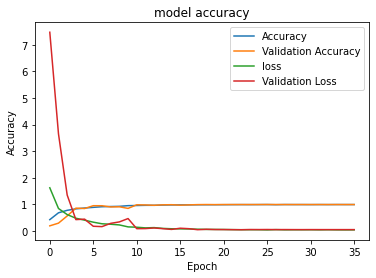

In [238]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [244]:
test_files = glob.glob(path.join(test_images_path, '*.jpg'))
saved_model_20 = load_model("./custom-acc1-val1-20.h5")
saved_model_30 = load_model("./custom-acc0.9858-val0.9891-30.h5")
# saved_model_40 = load_model("./custom-acc1-val0.9266.h5")
predictions = {}
video_count = 0
for testfile in test_files:
    key = testfile.split('/')[3].split('_')[0]
    if key not in predictions:
        print(f'New testfile: {key}, total count: {video_count}')
        predictions[key] = []
        video_count+=1
    data = np.array([np.array(Image.open(testfile))])
    data = data.astype(np.float) /255
    data = data.reshape(data.shape[0], 48, 48, 1)
    pred2 = saved_model_20.predict(data)
    pred3 = saved_model_30.predict(data)
#     pred4 = saved_model_40.predict(data)
    predictions[key].append(pred2.argmax())
    predictions[key].append(pred3.argmax())
#     predictions[key].append(pred4.argmax())

New testfile: test225, total count: 0
New testfile: test121, total count: 1
New testfile: test062, total count: 2
New testfile: test008, total count: 3
New testfile: test059, total count: 4
New testfile: test131, total count: 5
New testfile: test235, total count: 6
New testfile: test170, total count: 7
New testfile: test086, total count: 8
New testfile: test041, total count: 9
New testfile: test023, total count: 10
New testfile: test096, total count: 11
New testfile: test083, total count: 12
New testfile: test249, total count: 13
New testfile: test072, total count: 14
New testfile: test146, total count: 15
New testfile: test220, total count: 16
New testfile: test134, total count: 17
New testfile: test156, total count: 18
New testfile: test054, total count: 19
New testfile: test269, total count: 20
New testfile: test184, total count: 21
New testfile: test107, total count: 22
New testfile: test199, total count: 23
New testfile: test165, total count: 24
New testfile: test261, total count:

New testfile: test136, total count: 208
New testfile: test100, total count: 209
New testfile: test105, total count: 210
New testfile: test237, total count: 211
New testfile: test133, total count: 212
New testfile: test141, total count: 213
New testfile: test250, total count: 214
New testfile: test108, total count: 215
New testfile: test240, total count: 216
New testfile: test024, total count: 217
New testfile: test099, total count: 218
New testfile: test201, total count: 219
New testfile: test219, total count: 220
New testfile: test232, total count: 221
New testfile: test222, total count: 222
New testfile: test186, total count: 223
New testfile: test209, total count: 224
New testfile: test094, total count: 225
New testfile: test204, total count: 226
New testfile: test118, total count: 227
New testfile: test070, total count: 228
New testfile: test214, total count: 229
New testfile: test123, total count: 230
New testfile: test162, total count: 231
New testfile: test196, total count: 232


In [245]:
predictions

{'test225': [4,
  4,
  2,
  4,
  2,
  2,
  0,
  0,
  4,
  4,
  0,
  0,
  0,
  4,
  0,
  4,
  0,
  0,
  2,
  2,
  0,
  2,
  0,
  2,
  0,
  4,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  0,
  0,
  0,
  2,
  0,
  4,
  0,
  0,
  0,
  0,
  2,
  2,
  2,
  2,
  4,
  4,
  0,
  2,
  2,
  2,
  0,
  0,
  0,
  0,
  4,
  4],
 'test121': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'test062': [2,
  2,
  2,
  2,
  2,
  2,
  2,
  0,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2],
 'te

In [246]:
def most_common(lst):
    return max(set(lst), key=lst.count)

def searchKeysByVal(emotions, byVal):
    itemsList = emotions.items()
    for item in itemsList:
        if item[1] == byVal:
            return item[0]


In [247]:
output_data = []
for key, value in predictions.items():
    tip = most_common(value)
    probability = value.count(tip)/len(value)
    if probability <= 0.5:
        print(f"Best tip for {key}: {tip}-{searchKeysByVal(emotions_map, tip)} but it has {probability}")
    output_data.append([key, searchKeysByVal(emotions_map, tip)])

Best tip for test225: 2-Fear but it has 0.421875
Best tip for test041: 5-Surprise but it has 0.4375
Best tip for test033: 5-Surprise but it has 0.4375
Best tip for test022: 0-Anger but it has 0.5
Best tip for test228: 0-Anger but it has 0.484375
Best tip for test018: 0-Anger but it has 0.4375
Best tip for test142: 4-Sadness but it has 0.5
Best tip for test143: 3-Happiness but it has 0.5
Best tip for test101: 2-Fear but it has 0.46875
Best tip for test151: 5-Surprise but it has 0.5
Best tip for test172: 1-Disgust but it has 0.453125
Best tip for test144: 4-Sadness but it has 0.4375


In [256]:
# emotions_map = {'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Happiness':3, 'Sadness':4, 'Surprise':5}
print(predictions['test151'])

[5, 5, 2, 2, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 2, 2, 4, 4, 4, 4, 2, 3, 2, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 3, 2, 4, 2, 2, 2, 2, 2, 4, 5, 5, 2, 4, 5, 5, 5, 5, 2, 2, 2, 2, 5, 2, 5, 5, 2, 2, 5, 5]


In [225]:
import pandas as pd
output = pd.DataFrame(output_data, columns=['File', 'Label'])
output = output.sort_values(by='File')
output.to_excel('j1cei3_submission2-video.xlsx', index=False)

# 70-30 
Best tip for test225: 2-Fear but it has 0.46875

Best tip for test041: 5-Surprise but it has 0.3125

Best tip for test113: 5-Surprise but it has 0.4375

Best tip for test168: 1-Disgust but it has 0.4375

Best tip for test178: 1-Disgust but it has 0.40625

Best tip for test038: 4-Sadness but it has 0.5

Best tip for test049: 0-Anger but it has 0.4375

Best tip for test187: 1-Disgust but it has 0.4375

Best tip for test245: 5-Surprise but it has 0.5

Best tip for test151: 5-Surprise but it has 0.46875

Best tip for test144: 4-Sadness but it has 0.5

Best tip for test148: 3-Happiness but it has 0.5

Best tip for test115: 3-Happiness but it has 0.46875

# 80-20

Best tip for test225: 0-Anger but it has 0.5

Best tip for test008: 0-Anger but it has 0.48

Best tip for test066: 4-Sadness but it has 0.5

Best tip for test246: 4-Sadness but it has 0.5

Best tip for test018: 5-Surprise but it has 0.4375

Best tip for test102: 0-Anger but it has 0.46875

Best tip for test142: 3-Happiness but it has 0.4375

Best tip for test021: 0-Anger but it has 0.5

Best tip for test263: 3-Happiness but it has 0.375

Best tip for test101: 4-Sadness but it has 0.46875

Best tip for test218: 0-Anger but it has 0.46875

Best tip for test110: 0-Anger but it has 0.3125

Best tip for test144: 3-Happiness but it has 0.375

